In [1]:
import cudf

file_path = "../data/processed_file_cleaned.csv"

# Mapping Dictionnary
label_map = {
    'BENIGN': 'BENIGN',
    'Portscan': 'Portscan',
    'Bot': 'Bot',
    'FTP-Patator': 'Patator',
    'SSH-Patator': 'Patator',
    'DDoS': 'DOS/DDOS',
    'DoS Hulk': 'DOS/DDOS',
    'DoS GoldenEye': 'DOS/DDOS',
    'DoS slowloris': 'DOS/DDOS',
    'DoS Slowhttptest': 'DOS/DDOS',
    'Heartbleed': 'DOS/DDOS'
}

# Load with cuDF (GPU)
df = cudf.read_csv(file_path)
df.columns = df.columns.str.strip()

if 'Label' in df.columns:
    # Apply mapping via replace
    df['mapped_label'] = df['Label'].replace(label_map)

    #"Web Attack" with a mask
    mask_web = df['Label'].str.startswith("Web Attack")
    df.loc[mask_web, 'mapped_label'] = 'WebAttack'

    # Compter labels
    counts = df['mapped_label'].value_counts().to_pandas()  # conversion to pandas for display
    total = counts.sum()

    print("\n=== Label Summary (GPU) ===")
    for lbl, count in counts.items():
        ratio = (count / total) * 100
        print(f"{lbl}: {count} ({ratio:.2f}%)")
    print(f"\nTotal samples: {total}")
else:
    print("La colonne 'Label' est absente du fichier.")



=== Label Summary (GPU) ===
BENIGN: 2271320 (80.32%)
DOS/DDOS: 379748 (13.43%)
PortScan: 158804 (5.62%)
Patator: 13832 (0.49%)
WebAttack: 2180 (0.08%)
Bot: 1956 (0.07%)

Total samples: 2827840


In [2]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Dictionary to store the models
models = {}

# Load the LabelEncoder (shared across all models)
le_classes = np.load("../models/label_encoder_classes.npy")
le = LabelEncoder()
le.classes_ = le_classes
print("LabelEncoder loaded successfully")

# Load all XGBoost models
for i in range(1, 4):
    # v1: raw, v2: class weight, v3: bot cap
    model_path = f"../models/xgb_model_v{i}.json"
    model = xgb.XGBClassifier()
    model.load_model(model_path)
    models[f"v{i}"] = model
    print(f"xgb_model_v{i} loaded successfully")

print("\nAll models and the LabelEncoder loaded successfully!")

LabelEncoder loaded successfully
xgb_model_v1 loaded successfully
xgb_model_v2 loaded successfully
xgb_model_v3 loaded successfully

All models and the LabelEncoder loaded successfully!


In [3]:
import cudf
import cupy as cp

print("Loading test dataset...")

# Load X_test and y_test CSV (GPU-ready) 
X_test = cudf.read_csv("../data/train_test/X_test.csv")
y_test = cudf.read_csv("../data/train_test/y_test.csv").iloc[:, 0]

# Keep data on GPU (cuPy array) 
X_test_cp = X_test.to_cupy()
y_test_cp = y_test.to_cupy()

print("X_test and y_test loaded and transferred to GPU successfully!")

Loading test dataset...
X_test and y_test loaded and transferred to GPU successfully!


In [4]:
# Predictions
print("Making predictions on the test set...")

for version, model in models.items():
    print(f"\n--- {version} ---")
    
    # Predict -> encoded indices
    y_pred_encoded = model.predict(X_test.to_pandas())
    
    # Decode -> original class labels using the single LabelEncoder
    y_pred_labels = le.inverse_transform(y_pred_encoded)
    
    print("Predictions made successfully!")

Making predictions on the test set...

--- v1 ---
Predictions made successfully!

--- v2 ---
Predictions made successfully!

--- v3 ---
Predictions made successfully!



=== Evaluating v1 ===


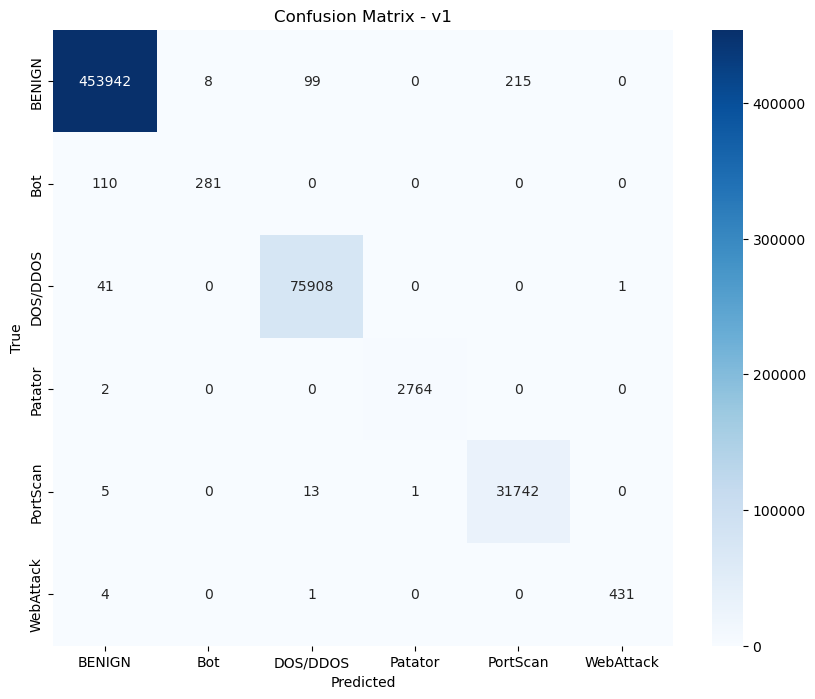


Classification Report:

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454264
         Bot       0.97      0.72      0.83       391
    DOS/DDOS       1.00      1.00      1.00     75950
     Patator       1.00      1.00      1.00      2766
    PortScan       0.99      1.00      1.00     31761
   WebAttack       1.00      0.99      0.99       436

    accuracy                           1.00    565568
   macro avg       0.99      0.95      0.97    565568
weighted avg       1.00      1.00      1.00    565568


Classification Report DataFrame:

              precision    recall  f1-score        support
BENIGN         0.999643  0.999291  0.999467  454264.000000
Bot            0.972318  0.718670  0.826471     391.000000
DOS/DDOS       0.998514  0.999447  0.998980   75950.000000
Patator        0.999638  0.999277  0.999458    2766.000000
PortScan       0.993272  0.999402  0.996328   31761.000000
WebAttack      0.997685  0.988532  0.993088

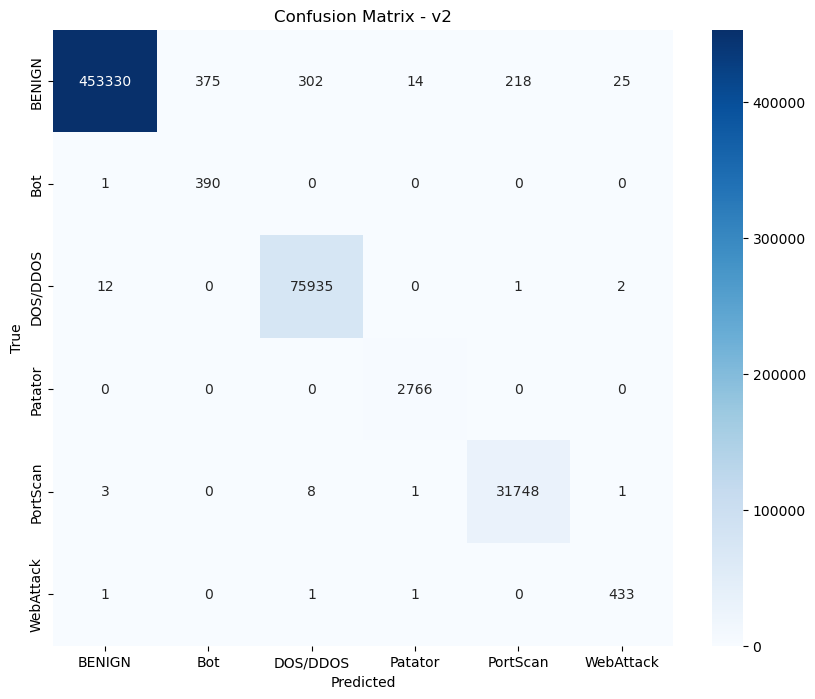


Classification Report:

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454264
         Bot       0.51      1.00      0.67       391
    DOS/DDOS       1.00      1.00      1.00     75950
     Patator       0.99      1.00      1.00      2766
    PortScan       0.99      1.00      1.00     31761
   WebAttack       0.94      0.99      0.97       436

    accuracy                           1.00    565568
   macro avg       0.91      1.00      0.94    565568
weighted avg       1.00      1.00      1.00    565568


Classification Report DataFrame:

              precision    recall  f1-score        support
BENIGN         0.999963  0.997944  0.998952  454264.000000
Bot            0.509804  0.997442  0.674740     391.000000
DOS/DDOS       0.995921  0.999803  0.997858   75950.000000
Patator        0.994249  1.000000  0.997116    2766.000000
PortScan       0.993149  0.999591  0.996360   31761.000000
WebAttack      0.939262  0.993119  0.965440

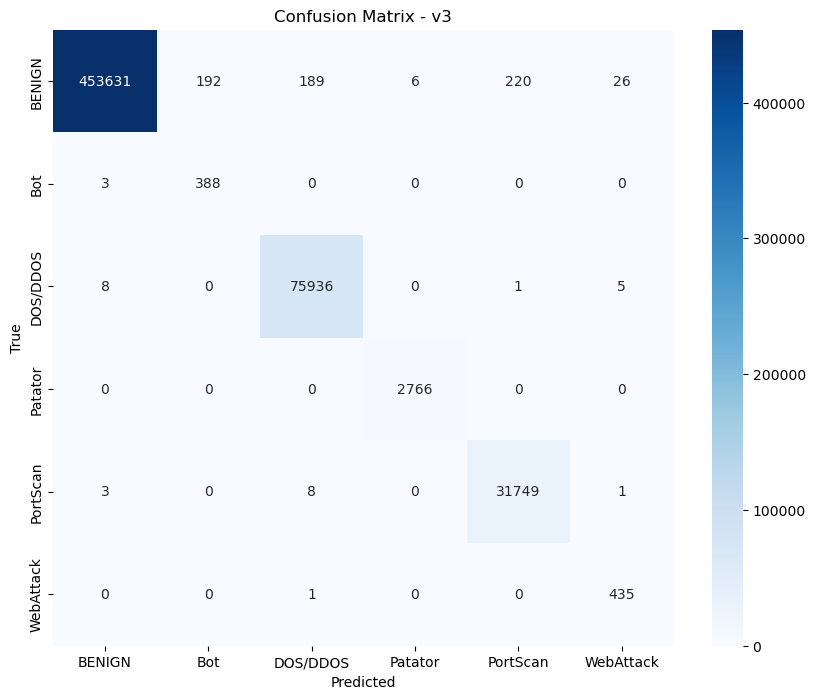


Classification Report:

              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    454264
         Bot       0.67      0.99      0.80       391
    DOS/DDOS       1.00      1.00      1.00     75950
     Patator       1.00      1.00      1.00      2766
    PortScan       0.99      1.00      1.00     31761
   WebAttack       0.93      1.00      0.96       436

    accuracy                           1.00    565568
   macro avg       0.93      1.00      0.96    565568
weighted avg       1.00      1.00      1.00    565568


Classification Report DataFrame:

              precision    recall  f1-score        support
BENIGN         0.999969  0.998607  0.999287  454264.000000
Bot            0.668966  0.992327  0.799176     391.000000
DOS/DDOS       0.997399  0.999816  0.998606   75950.000000
Patator        0.997835  1.000000  0.998917    2766.000000
PortScan       0.993087  0.999622  0.996344   31761.000000
WebAttack      0.931478  0.997706  0.963455

In [5]:
# Display the results

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import pandas as pd

# Convert ground truth to CPU numpy
y_test_cpu = y_test.to_numpy()
class_names = le.classes_.tolist()

for version, model in models.items():
    print(f"\n=== Evaluating {version} ===")

    # Prediction
    # safest way: convert test set to pandas (avoids GPU/CPU mismatch issues)
    y_pred_encoded = model.predict(X_test.to_pandas())

    # Confusion matrix 
    cm = confusion_matrix(y_test_cpu, y_pred_encoded)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {version}')
    plt.show()

    # Classification report (text)
    print("\nClassification Report:\n")
    print(classification_report(y_test_cpu, y_pred_encoded, target_names=class_names))

    # Report as pandas DataFrame 
    report_dict = classification_report(y_test_cpu, y_pred_encoded, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    print("\nClassification Report DataFrame:\n")
    print(report_df)

    # Global metrics
    f1_macro = f1_score(y_test_cpu, y_pred_encoded, average='macro')
    f1_micro = f1_score(y_test_cpu, y_pred_encoded, average='micro')
    accuracy = accuracy_score(y_test_cpu, y_pred_encoded)
    precision_macro = precision_score(y_test_cpu, y_pred_encoded, average='macro')
    recall_macro = recall_score(y_test_cpu, y_pred_encoded, average='macro')

    print(f"\nGlobal Metrics ({version}):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print(f"F1-score (micro): {f1_micro:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
